# Intermediate: Retrieve TESS Pixel Response Function Image
TESS provides Pixel Response Functions (PRFs) **Note Define PRF** that can be used to fit the data. This notebook shows you how to retrieve a PRF image for the closest pixel and sub-pixel location. 

More information about the pixel response function can be found in the [TESS Archive Manual.](https://outerspace.stsci.edu/display/TESS/TESS+Archive+Manual) The PRF models were created by the mission by fitting to micro-dithered data taken during PRF commissioning exercises. See the Instrument Handbook for details on the data collection. The pixel response functions in FITS or Matlab format and are available from the models/prf_fitsfiles directory.

This tutorial starts by defining some functions about how to parse the FITS formated PRF files.  It then defines a main funtion to retrieve a specific PRF image. 

### Description of the PRF retrieval code
The primary function (`getPrfAtColRowFits`) should take a column, row, ccd, camera and sector and return a 13x13 image of the best PRF.  It uses the ccd, camera and sector information to determine the name of the relevant PRF file in `pathLookup`. Then in `determineClosestTessRowCol` use the requested row and column, find the 4 nearest positions on the detector for which the mission provided a PRF file. Open those files and pull out the appropriate sub-pixel image.  The missions provided 13x13 PRF images for 9x9 sub-pixel locations. Those images are interleaved into one 117x117 image. Once the four 13x13 sub-pixel PRF images are extracted, `interpolatePrf` interpolates them to the specfied pixel location. The main function then returns this interpolated PRF image.


## Functions to retrieve a TESS PRF

In [1]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt

### Determine the name of the PRF based on ccd camera and sector

In [2]:
def pathLookup(ccd, camera, sector):
    """
    Get the pieces you need to identify the precise file name of your PRF.
    The datestring and directory name can be found from the ccd, camera and sector.
    
    """ 
    if sector < 1:
        raise ValueError("Sector must be greater than 0.")
    if (camera > 4) | (ccd > 4):
        raise ValueError("Camera or CCD is larger than 4.")

    if sector <= 3:
        add_path = "/start_s0001/"
        datestring = "2018243163600"

        if camera >= 3:
            datestring = "2018243163601"
        elif (camera == 2) & (ccd == 4):
            datestring = "2018243163601"
        
    else:
        add_path = "/start_s0004/"
        datestring = "2019107181900"
        if (camera == 1) & (ccd >= 2):
            datestring = "2019107181901"
        elif (camera == 2):
            datestring = "2019107181901"
        elif (camera == 3) & (ccd >=2) :
            datestring = "2019107181902"
        elif (camera == 4):
            datestring = "2019107181902"

    return datestring, add_path

### Read in one PRF FITS File

In [3]:
def readOnePrfFitsFile(ccd, camera, col, row, path, datestring):
    """
    reads in the full, interleaved prf Array for a single row,col,ccd,camera location.
    
    Inputs
    -------
    ccd
        (int) CCD number
    camera
        (int) Camera number
    col
        (float) Specific column where the PRF was sampled.
    row
        (float) Specific row where the PRF was sampled.
    path
        (string) The full path of the data file. Can be the MAST Web address
        
    Returns
    ------
    prfArray
        (np array) Full 117 x 117 interleaved prf Array for the requested file.
        
    """
        
    fn = "cam%u_ccd%u/tess%13s-prf-%1u-%1u-row%04u-col%04u.fits" % \
        (camera, ccd, datestring, camera, ccd, row, col)

    filepath = os.path.join(path, fn)
    #print(filepath)
    hdulistObj = fits.open(filepath)
    prfArray = hdulistObj[0].data

    return prfArray

#@TODO Better name? and docstring
def determineClosestTessColRow(col,row):
    """
    Determine the four pairs of row, col positions of your target. 
    These are specific to TESS and where they chose to report their PRFs.
    Returns a list of (col,row) pairs.
    """

    posRows = np.array([1, 513, 1025, 1536, 2048])
    posCols = np.array([45, 557, 1069, 1580,2092])

    difcol = np.abs(posCols - col)
    difrow = np.abs(posRows - row)

    #Expand out to the four image position to interpolate between,
    #Return as a list of tuples.
    imagePos = []
    for r in posRows[np.argsort(difrow)[0:2]]:
        for c in posCols[np.argsort(difcol)[0:2]]:
            imagePos.append((c,r))

    return imagePos

In [4]:
def getOffsetsFromPixelFractions(col, row):
    """
    Map the fractional part of the col,row position to an offset into the
    full prf image. For example, if (col, row) = (123.4, 987.6), then
    (colFrac, rowFrac) = (.4, .6). colOffset
    Returns the initial offset for addressing the interleaved PRF array.
    to ensure you get the location appropriate for your sub-pixel values.

    """
    gridSize = 9

    colFrac = np.remainder(float(col), 1)
    rowFrac = np.remainder(float(row), 1)

    colOffset = gridSize - np.round(gridSize * colFrac) - 1
    rowOffset = gridSize - np.round(gridSize * rowFrac) - 1

    return int(colOffset), int(rowOffset)

def getRegSampledPrfFitsByOffset(prfArray, colOffset, rowOffset):
    """
    The 13x13 pixel PRFs on at each grid location are sampled at a 9x9 intra-pixel grid, to
    describe how the PRF changes as the star moves by a fraction of a pixel in row or column.
    To extract out a single PRF, you need to address the 117x117 array in a funny way
    (117 = 13x9),

    .. code-block:: python

        img = array[ [colOffset, colOffset+9, colOffset+18, ...],
                     [rowOffset, rowOffset+9, ...] ]
    """
    gridSize = 9

    assert colOffset < gridSize
    assert rowOffset < gridSize

    #Number of pixels in regularly sampled PRF. Should be 13x13
    nColOut, nRowOut = prfArray.shape
    nColOut /= float(gridSize)
    nRowOut /= float(gridSize)

    iCol = colOffset + (np.arange(nColOut) * gridSize).astype(np.int)
    iRow = rowOffset + (np.arange(nRowOut) * gridSize).astype(np.int)

    tmp = prfArray[iRow, :]
    prf = tmp[:,iCol]

    return prf


In [5]:
def interpolatePrf(regPrfArray, col, row, imagePos):
    """
    Interpolate between 4 images to find the best PRF at col, row
    This is a simple linear interpolation.
    regPrfArray is a 13x13x4 prf image array of the four nearby locations.
    row col is the location you want the prf at.
    imagePos is a list of 4 (col,row) locations
    """
    p11, p21, p12, p22 = regPrfArray
    c0 = imagePos[0][0]
    c1 = imagePos[1][0]
    r0 = imagePos[0][1]
    r1 = imagePos[2][1]

    assert c0 != c1
    assert r0 != r1

    dCol = (col-c0) / (c1-c0)
    dRow = (row-r0) / (r1 - r0)

    #Intpolate across the rows
    tmp1 = p11 + (p21 - p11) * dCol
    tmp2 = p12 + (p22 - p12) * dCol

    #Interpolate across the columns
    out = tmp1 + (tmp2-tmp1) * dRow
    return out

## The main function

In [8]:
def getPrfAtColRowFits(col, row, ccd, camera, sector, path):
    """
    Main Function
    Lookup a 13x13 PRF image for a single location
    
    Inputs
    ---------
    col, row
        (floats) Location on CCD to lookup. The origin of the CCD is the bottom left.
        Increasing column increases the "x-direction", and row increases the "y-direction"
        The column coordinate system starts at column 45.
    ccd
        (int) CCD number. There are 4 CCDs per camera
    camera
        (int) Camera number. The instrument has 4 cameras
    sector
        (int)  Sector number, greater than or equal to 1.
    path
        (str) Directory or URL where the PRF fits files are located

    Returns
    ---------
    A 13x13 numpy image array.
    """
    col = float(col)
    row = float(row)
    prfImages = []
    
    #Determine a datestring in the file name and the path based on ccd/camera/sector
    #print(path)
    datestring, subDirectory = pathLookup(ccd, camera, sector)
    #print(datestring, subDirectory)
    path = path + subDirectory
    #print("***")
    #print(path, path2)
    #import pdb; pdb.set_trace()
    
    #Convert the fractional pixels to the offset required for the interleaved pixels.
    colOffset, rowOffset = getOffsetsFromPixelFractions(col, row)
    
    #Determine the 4 (col,row) locations with exact PRF measurements.
    imagePos = determineClosestTessColRow(col, row)


    #Loop over the 4 locations and read in each file and extract the sub-pixel location.
    for pos in imagePos:
            prfArray = readOnePrfFitsFile(ccd, camera, pos[0], pos[1], path, datestring)
            
            img = getRegSampledPrfFitsByOffset(prfArray, colOffset, rowOffset)       
            prfImages.append(img)

    #Simple linear interpolate across the 4 locations.
    interpolatedPrf = interpolatePrf(prfImages, col, row, imagePos)

    return interpolatedPrf

In [9]:
def getNearestPrfFits(col, row, ccd, camera, sector, path):
    """
    Main Function
    Return a 13x13 PRF image for a single location. No interpolation
    
    This function is identical to getPrfAtColRowFits except it does not perform the interpolation step.
    
    Inputs
    ---------
    col, row
        (floats) Location on CCD to lookup. The origin of the CCD is the bottom left.
        Increasing column increases the "x-direction", and row increases the "y-direction"
        The column coordinate system starts at column 45.
    ccd
        (int) CCD number. There are 4 CCDs per camera
    camera
        (int) Camera number. The instrument has 4 cameras
    sector
        (int)  Sector number, greater than or equal to 1.

    Returns
    ---------
    A 13x13 numpy image array.
    """
    col = float(col)
    row = float(row)
    prfImages = []
    
    #Determine a datestring in the file name and the path based on ccd/camer/sector
    datestring, addPath = pathLookup(ccd, camera, sector)
    path = path + addPath
    
    #Convert the fractional pixels to the offset required for the interleaved pixels.
    colOffset, rowOffset = getOffsetsFromPixelFractions(col, row)
    
    #Determine the 4 (col,row) locations with exact PRF measurements.
    imagePos = determineClosestTessColRow(col, row)
    bestPos = imagePos[0]
    prfArray = readOnePrfFitsFile(ccd, camera, bestPos[0], bestPos[1], path, datestring)
            
    prfImage = getRegSampledPrfFitsByOffset(prfArray, colOffset, rowOffset)       

    return prfImage

### Create PRFs using the above functions
Notice that `getPrfAtColRowFits()` can accept either a path to the location on your local machine where the PRF fits files are stored, or a URL pointing to the same directory at MAST.  We recommend downloading the PRF fits files if you expect to use them frequently.

In [13]:
#Define the location for which we want to retrieve the PRF.
col = 125.23
row = 544.1
ccd = 2
camera = 2
sector = 1
#This is the directory where MAST stores the prf FITS files.
path = "https://archive.stsci.edu/missions/tess/models/prf_fitsfiles/"

prf = getPrfAtColRowFits(col, row, ccd, camera, sector, path)
closestPrf = getNearestPrfFits(col, row, ccd, camera, sector, path)

Below is the code to plot both the closest PRF and a PRF derived from a linear interpolation between the 4 nearest PRFs provided in the file.  I plotted them with a log scale in order to let you really see the full extent of the PRFs.  Also, I take the difference so you can see how much they differ.

0.0013053230685281109
0.0017403752205790435


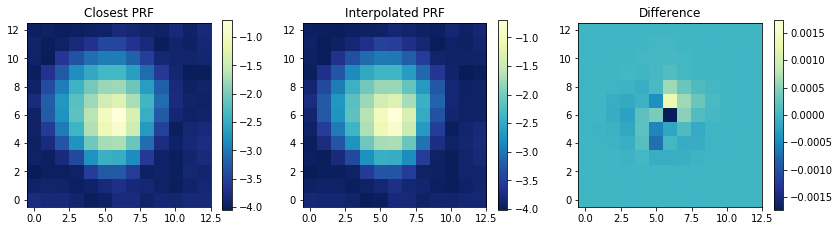

In [22]:
kwargs = {'origin':'bottom', 'interpolation':'nearest', 'cmap':plt.cm.YlGnBu_r}
plt.figure(figsize=(14,3.5))
plt.subplot(131)
plt.imshow(np.log10(closestPrf), **kwargs)
plt.colorbar()
plt.title('Closest PRF')
plt.subplot(132)
plt.imshow(np.log10(prf), **kwargs)
plt.colorbar()
plt.title('Interpolated PRF')
plt.subplot(133)

diff = closestPrf - prf
plt.imshow(diff, **kwargs)
mx = max( np.max(diff), np.fabs(np.min(diff)))
plt.clim(-mx, mx)
plt.title('Difference')
plt.colorbar()

## Variation of the pixel response function across one pixel
The PRF varies quite a bit depending on where on the pixel the star's light falls.  As a result it is instructive to plot the PRF for one pixel at various intrapixel locations.  In the following we show a 5x5 grid of the prf above. Note that there are actually 9 different intrapixel locations provided in the TESS Mission PRFs.  Here we plot them on a linear scale because most of the variation is in the brightest pixels of the PRF.

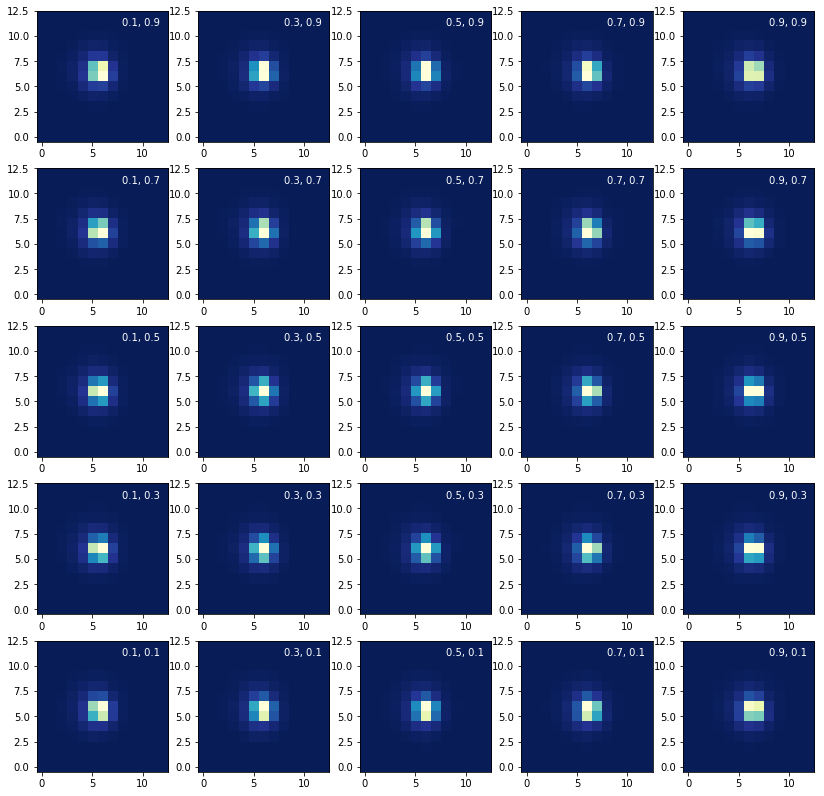

In [28]:
#Define the location for which we want to retrieve the PRF.
col = 125.0
row = 1044.0
ccd = 2
camera = 2
sector = 1
#This is the directory where MAST stores the prf FITS files.
path = "https://archive.stsci.edu/missions/tess/models/prf_fitsfiles/"

kwargs['vmax'] = .2  
plt.figure(figsize=(14, 14))
#Loop over the 5 different locations
nplot=0
for row_add in np.arange(0.9, 0, -.2):
    for col_add in np.arange(0.1, 1, .2):
        nplot=nplot+1
        plt.subplot(5,5,nplot)
        prf = getPrfAtColRowFits(col + col_add, row + row_add, ccd, camera, sector, path)
        plt.imshow(prf, **kwargs)
        plt.annotate("%.1f, %.1f" % (col_add,row_add),(8,11),color='w')
        
_ = kwargs.pop('vmax')  #unset vmax


## Sample of PRFs across the chip
Let's do the same experiment but sampled across a single CCD. The PRF images are plotted using a log scale to see the difference in the wings of the PRF. As an experiment you should change the ccd, camera and sector integers to see how it varies from one CCD to another across the TESS field of view.

@TODO Describe where the centre of the focal plane is in this next plot

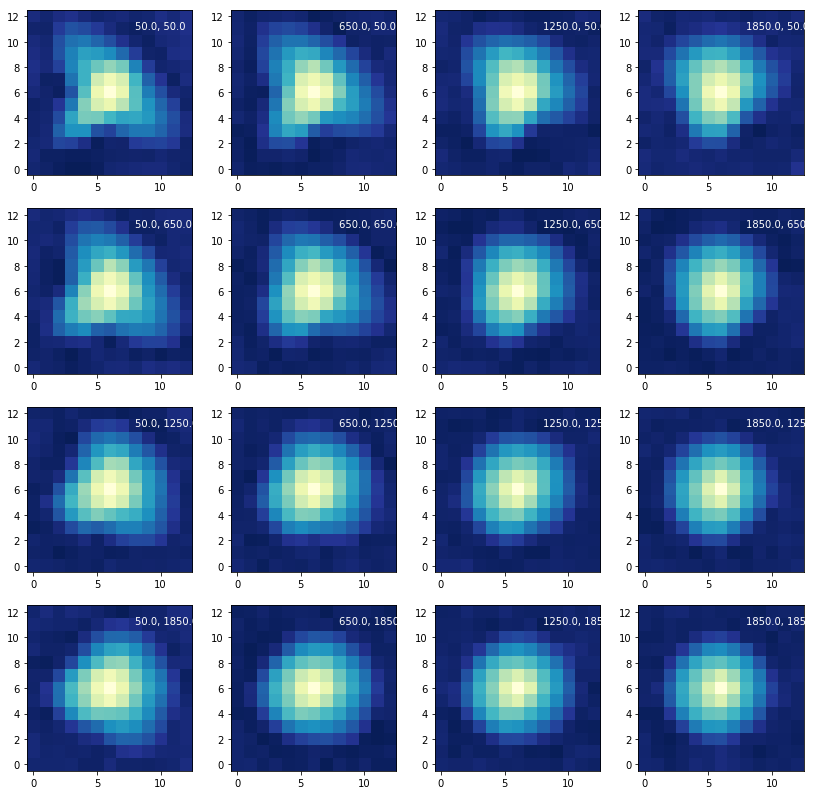

In [11]:
#Define the CCD for which we want to retrieve the PRFs
sector = 1   # Values 1--13
camera = 3   #values 1--4
ccd = 1  #Values 1 -- 4
#This is the directory where MAST stores the prf FITS files.
path = "https://archive.stsci.edu/missions/tess/models/prf_fitsfiles/"

plt.figure(figsize=(14, 14))
plt.title("Intra Pixel PRF")
#Loop over the 5 different locations
nplot=0
for row in np.arange(50, 1851, 600):
    for col in np.arange(50, 1851, 600):
        nplot=nplot + 1
        plt.subplot(4, 4, nplot)
        prf = getPrfAtColRowFits(col + .5, row + .5, ccd, camera, sector, path)
        plt.imshow(np.log10(prf), **kwargs)
        plt.annotate("%.1f, %.1f" % (col, row), (8,11), color='w')

### Compare the PRF to an Image
Now we pull down the image of a star using TessCut and Catalogs, both available through astroquery.mast. MAST maintains separate tutorial on how to use these tools. Tesscut cuts out a time series of a subsection of the TESS FFIs.  We plot that image and attmept to estimate a PRF for that star. This examples is done for TIC 307214209. It is chosen because it is relatively isolated in the field, making it easier to match the PRFs.


In [29]:
from astroquery.mast import Tesscut
from astroquery.mast import Catalogs

ticid = 307214209
target = "TIC %u" % ticid
size = 13

catalogData = Catalogs.query_criteria(catalog = "Tic", ID = ticid)
ra = catalogData['ra']
dec = catalogData['dec']

coord="%f, %f" % (ra,dec)

### Use Tesscut to retrieve a 13x13 square image from a calibrated FFI
TESScut requires a string containing the RA and Dec of the location and a size for how big the cutout should be. I then take the median of all the images in the stack for comparison to the PRF.  The Header contains information about the location of the pixels on the original calibrated FFI. 1CRV4P and 2CRV4P provide the column and row of the center of the cutout in the original physical coordinate system of the FFI.

In [30]:
hdulist=Tesscut.get_cutouts(coord, size=size)
n=1 #There is more than one sector, we chose the second one

In [31]:
#Get the image of the median of the time series.
image_array = hdulist[n][1].data['FLUX']
image_stack = np.median(image_array,axis=0)

In [32]:
#Pull out the location of the middle of the CCD from the Physics WCS in the header.
image_head = hdulist[n][1].header
prime_head = hdulist[n][0].header
ap_head = hdulist[n][2].header
col_center = image_head['1CRV4P']
row_center = image_head['2CRV4P']
print("%f, %f" % (col_center, row_center))

1041.000000, 75.000000


### Adjust for actual location of the star
Usually, if the TIC is accurate, the location of the star will be right in the center. In case it is not, we look for the brightest pixel in the image and request our PRF for that location. 

In [35]:
sortedindex=np.dstack(np.unravel_index(np.argsort(image_stack.ravel()), (13, 13)))
brightest = sortedindex[-1][-1]
bright_col = brightest[0] - 6 + col_center
bright_row = brightest[1] - 6 + row_center
print(bright_col,bright_row)

#Define the location for which we want to retrieve the PRF.
#Recall that the PRF starts at column 44, so we need to add 44 to the column of our star.
#@TODO Define a variable and set it to 44, use the variable through the code
col = bright_col + 44.
row = bright_row


1041 75


### Look up Sector, Camera, and CCD

In [ ]:
camera = prime_head['CAMERA']
ccd = prime_head['CCD']
sector = prime_head['SECTOR']
#This is the directory where MAST stores the prf FITS files.
path = "https://archive.stsci.edu/missions/tess/models/prf_fitsfiles/"


### Plot the sub-pixel PRFs
We are going to compare the image from the FFI to the various sub-pixel locations to choose the one that looks most like the image. For most use cases, you would most likely want to perform a fit, but for our purposes of understanding the PRFs, this will be sufficient.

Here is the stacked image

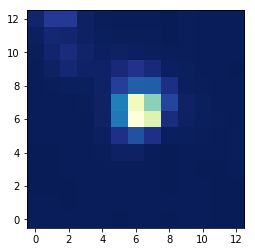

In [39]:
plt.imshow(image_stack, **kwargs)

Here is a 5x5 grid showing the PRF as it would look if it fell on different parts of the pixel. My quick chi-by-eye tells me that (0.7,0.9) is a pretty good match.

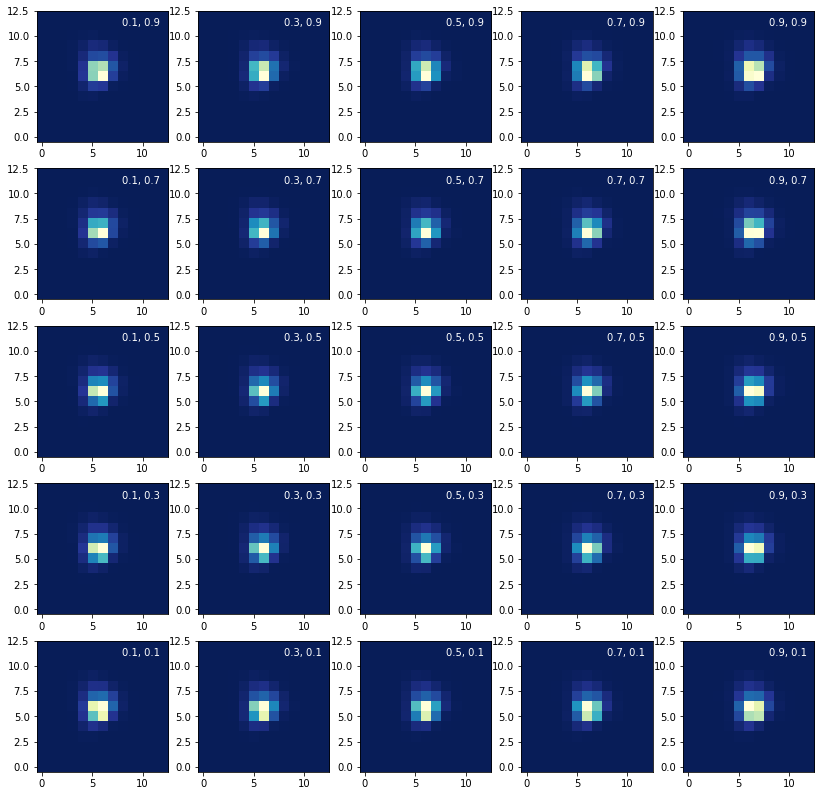

In [41]:
plt.figure(figsize=(14, 14))
#Loop over the 5 different locations
nplot=0
for row_add in np.arange(0.9, 0, -.2):
    for col_add in np.arange(0.1,1,.2):
        nplot=nplot+1
        plt.subplot(5,5,nplot)
        prf = getPrfAtColRowFits(col + col_add, row + row_add, ccd, camera, sector, path)
        plt.imshow(prf, **kwargs)
        plt.annotate("%.1f, %.1f" % (col_add,row_add),(8,11),color='w')

Here I ask for the interpolated PRF for the specific row and column using the subpixel information. Notice the 44 pixel offset added in because the PRFs use 45 as their first column but the calibrated FFIs use 1 as the first column. 


In [49]:
#offsets from the corner of the pixel.
offcol = .7
offrow = .9
#44 pixel offset in the PRFs for columns.
#Retrieve the PRF using our functions above.
prf = getPrfAtColRowFits(col + offcol + 44, row+offrow, ccd, camera, sector, path)

### Compare PRF and FFI
Here we look at the difference between our image and the PRF we obtained. First subtract the background and scale up the PRF based on the flux in the brightest pixel. 

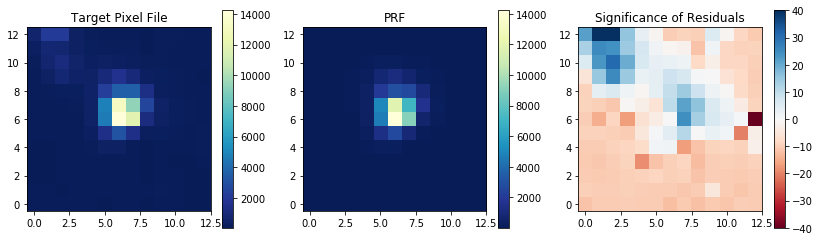

In [50]:
#estimate background using median
image_subbkg =  image_stack - np.median(image_stack)
#Scaling based on brightest pixels.
scale = np.max(image_subbkg)/np.max(prf)
#Take the difference
diff =  image_subbkg - prf * scale 
#Estimate the signficance of the residuals
sigma = diff/(np.sqrt(np.abs(image_subbkg))+.05)

#Plot
vm = np.max(image_subbkg)
plt.figure(figsize=(14,4))
plt.subplot(131)
plt.imshow(image_stack, **kwargs, vmax=vm)
plt.title('Target Pixel File')
plt.colorbar()

plt.subplot(132)
plt.imshow(prf*scale,**kwargs, vmax=vm)
plt.title('PRF')
plt.colorbar()

plt.subplot(133)
plt.imshow(sigma, origin="bottom", interpolation='nearest',cmap = 'RdBu', vmin=-40,vmax=40)
plt.title('Significance of Residuals')
plt.colorbar()


### Residuals
This is not an optimal fit. By playing around with `coloffset` and `rowoffset` above, you will be able to find a slightly better fit than the one shown above. We also did not account for all the stars in our image. We picked a rather isolated, 8th magnitude star, but there is still another 10th magnitude star about 7 pixels away, and a 15th magnitude star about 5 pixels away from our star (both are towards the upper left in our image). A good prf fit will include all of this information. Both of these can be seen clearly in the residuals. We also see some residual signal from our primary star that hopefully a better fit that properly scales the PRF to the flux of the star will remove more cleanly.

<a id="about_ID"></a>
## About this Notebook
**Authors:** 
<BR>Susan E. Mullally, STScI Senior Archive Scientist
<BR>Fergal Mullally
<br>**Updated On:** 2019-05-22

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 

### Assert Statements
No need to mess with these.

In [21]:
#An Assert statement to ensure that the PRFs are being calculated correctly
prf = getPrfAtColRowFits(120.1, 500.0, 1, 2, 1, "https://archive.stsci.edu/missions/tess/models/prf_fitsfiles/")
assert np.abs(prf[0,0] - 0.00023311895) < 2e-10